
Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 3 Predicting Online Ad Click-Through with Tree-Based Algorithms 

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)

# The metrics for measuring a split 

## Gini Impurity 

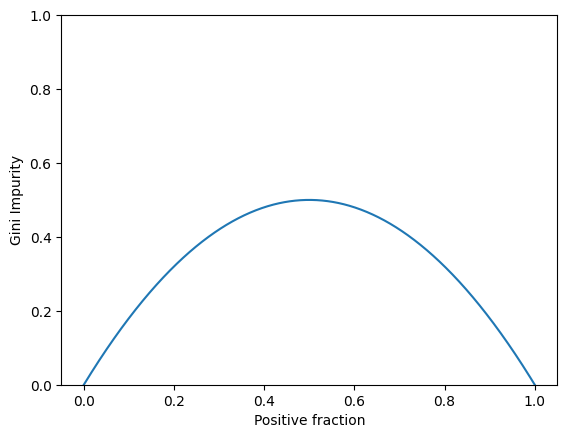

In [1]:
import matplotlib.pyplot as plt
import numpy as np


# Plot Gini Impurity in binary case
pos_fraction = np.linspace(0.00, 1.00, 1000)
gini = 1 - pos_fraction**2 - (1-pos_fraction)**2
plt.plot(pos_fraction, gini)
plt.xlabel('Positive fraction')
plt.ylabel('Gini Impurity')
plt.ylim(0, 1)
plt.show()

In [2]:
# Given labels of a data set, the Gini Impurity calculation function
def gini_impurity(labels):
    # When the set is empty, it is also pure
    if len(labels) == 0:
        return 0
    # Count the occurrences of each label
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return 1 - np.sum(fractions ** 2)


print(f'{gini_impurity([1, 1, 0, 1, 0]):.4f}')
print(f'{gini_impurity([1, 1, 0, 1, 0, 0]):.4f}')
print(f'{gini_impurity([1, 1, 1, 1]):.4f}')

0.4800
0.5000
0.0000


## Information Gain 

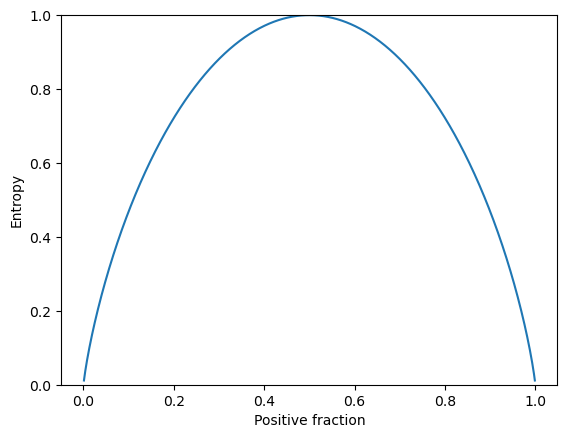

In [3]:
# Plot entropy in binary case
pos_fraction = np.linspace(0.001, 0.999, 1000)
ent = - (pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))
plt.plot(pos_fraction, ent)
plt.xlabel('Positive fraction')
plt.ylabel('Entropy')
plt.ylim(0, 1)
plt.show()

In [4]:
# Given labels of a data set, the entropy calculation function
def entropy(labels):
    if len(labels) == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1]
    fractions = counts / float(len(labels))
    return - np.sum(fractions * np.log2(fractions))

print(f'{entropy([1, 1, 0, 1, 0]):.4f}')
print(f'{entropy([1, 1, 0, 1, 0, 0]):.4f}')
print(f'{entropy([1, 1, 1, 1]):.4f}')


0.9710
1.0000
-0.0000


In [5]:
# def information_gain(y, mask, func=entropy):
#     s1 = np.sum(mask)
#     s2 = mask.size - s1
#     if (s1 == 0 | s2 == 0): return 0
#     return func(y) - s1 / float(s1 + s2) * func(y[mask]) - s2 / float(s1 + s2) * func(y[np.logical_not(mask)])

In [6]:
criterion_function = {'gini': gini_impurity, 'entropy': entropy}
def weighted_impurity(groups, criterion='gini'):
    """
    Calculate weighted impurity of children after a split
    @param groups: list of children, and a child consists a list of class labels
    @param criterion: metric to measure the quality of a split, 'gini' for Gini Impurity or 'entropy' for Information Gain
    @return: float, weighted impurity
    """
    total = sum(len(group) for group in groups)
    weighted_sum = 0.0
    for group in groups:
        weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
    return weighted_sum


children_1 = [[1, 0, 1], [0, 1]]
children_2 = [[1, 1], [0, 0, 1]]
print(f"Entropy of #1 split: {weighted_impurity(children_1, 'entropy'):.4f}")
print(f"Entropy of #2 split: {weighted_impurity(children_2, 'entropy'):.4f}")


Entropy of #1 split: 0.9510
Entropy of #2 split: 0.5510


# Implementing a decision tree from scratch 

In [7]:
def split_node(X, y, index, value):
    """
    Split data set X, y based on a feature and a value
    @param X: numpy.ndarray, dataset feature
    @param y: numpy.ndarray, dataset target
    @param index: int, index of the feature used for splitting
    @param value: value of the feature used for splitting
    @return: list, list: left and right child, a child is in the format of [X, y]
    """
    x_index = X[:, index]
    # if this feature is numerical
    if X[0, index].dtype.kind in ['i', 'f']:
        mask = x_index >= value
    # if this feature is categorical
    else:
        mask = x_index == value
    # split into left and right child
    left = [X[~mask, :], y[~mask]]
    right = [X[mask, :], y[mask]]
    return left, right

In [8]:
def get_best_split(X, y, criterion):
    """
    Obtain the best splitting point and resulting children for the data set X, y
    @param X: numpy.ndarray, dataset feature
    @param y: numpy.ndarray, dataset target
    @param criterion: gini or entropy
    @return: dict {index: index of the feature, value: feature value, children: left and right children}
    """
    best_index, best_value, best_score, children = None, None, 1, None
    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_impurity([groups[0][1], groups[1][1]], criterion)
            if impurity < best_score:
                best_index, best_value, best_score, children = index, value, impurity, groups
    return {'index': best_index, 'value': best_value, 'children': children}

In [9]:
def get_leaf(labels):
    # Obtain the leaf as the majority of the labels
    return np.bincount(labels).argmax()

In [10]:
def split(node, max_depth, min_size, depth, criterion):
    """
    Split children of a node to construct new nodes or assign them terminals
    @param node: dict, with children info
    @param max_depth: int, maximal depth of the tree
    @param min_size: int, minimal samples required to further split a child
    @param depth: int, current depth of the node
    @param criterion: gini or entropy
    """
    left, right = node['children']
    del (node['children'])
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return
    # Check if the current depth exceeds the maximal depth
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1])
        return
    # Check if the left child has enough samples
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else:
        # It has enough samples, we further split it
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['left'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else:
            node['left'] = result
            split(node['left'], max_depth, min_size, depth + 1, criterion)
    # Check if the right child has enough samples
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else:
        # It has enough samples, we further split it
        result = get_best_split(right[0], right[1], criterion)
        result_left, result_right = result['children']
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1])
        else:
            node['right'] = result
            split(node['right'], max_depth, min_size, depth + 1, criterion)

In [11]:
def train_tree(X_train, y_train, max_depth, min_size, criterion='gini'):
    """
    Construction of a tree starts here
    @param X_train: list of training samples (feature)
    @param y_train: list of training samples (target)
    @param max_depth: int, maximal depth of the tree
    @param min_size: int, minimal samples required to further split a child
    @param criterion: gini or entropy
    """
    X = np.array(X_train)
    y = np.array(y_train)
    root = get_best_split(X, y, criterion)
    split(root, max_depth, min_size, 1, criterion)
    return root

In [12]:
X_train = [['tech', 'professional'],
           ['fashion', 'student'],
           ['fashion', 'professional'],
           ['sports', 'student'],
           ['tech', 'student'],
           ['tech', 'retired'],
           ['sports', 'professional']]

y_train = [1,
           0,
           0,
           0,
           1,
           0,
           1]

tree = train_tree(X_train, y_train, 2, 2)

In [13]:
CONDITION = {'numerical': {'yes': '>=', 'no': '<'},
             'categorical': {'yes': 'is', 'no': 'is not'}}
def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if node['value'].dtype.kind in ['i', 'f']:
            condition = CONDITION['numerical']
        else:
            condition = CONDITION['categorical']
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['no'], node['value']))
        if 'left' in node:
            visualize_tree(node['left'], depth + 1)
        print('{}|- X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['yes'], node['value']))
        if 'right' in node:
            visualize_tree(node['right'], depth + 1)
    else:
        print(f"{depth * '  '}[{node}]")


visualize_tree(tree)


|- X1 is not fashion
  |- X2 is not professional
    [0]
  |- X2 is professional
    [1]
|- X1 is fashion
  [0]


In [14]:
X_train_n = [[6, 7],
           [2, 4],
           [7, 2],
           [3, 6],
           [4, 7],
           [5, 2],
           [1, 6],
           [2, 0],
           [6, 3],
           [4, 1]]

y_train_n = [0,
           0,
           0,
           0,
           0,
           1,
           1,
           1,
           1,
           1]

tree = train_tree(X_train_n, y_train_n, 2, 2)
visualize_tree(tree)


|- X2 < 4
  |- X1 < 7
    [1]
  |- X1 >= 7
    [0]
|- X2 >= 4
  |- X1 < 2
    [1]
  |- X1 >= 2
    [0]


# Implementing a decision tree with scikit-learn 

In [15]:
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=2)
tree_sk.fit(X_train_n, y_train_n)


DecisionTreeClassifier(max_depth=2)

In [16]:
from sklearn.tree import export_graphviz
export_graphviz(tree_sk, out_file='tree.dot', feature_names=['X1', 'X2'], impurity=False, filled=True, class_names=['0', '1'])


---

Readers may ignore the next cell.

In [17]:
!jupyter nbconvert --to python ch3_part1.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch3_part1.ipynb to python
[NbConvertApp] Writing 9476 bytes to ch3_part1.py
